**Задание на лабораторную работу.**

Разработать собственную реализацию байесовского классификатора в виде программы
на языке Python и сравнить точность и производительность полученного алгоритма с
методами библиотеки sklearn. Использовать наборы данных, полученные при выполнении лабораторной работы 1. Производительность оценивать, путём замера времени работы алгоритма классификации. 

*Для каждого алгоритма измерение проводить несколько раз.*

*Результаты представить в виде нескольких гистограмм на одном графике.*

**Результаты, которые необходимо получить в итоге:**
1. График производительности алгоритмов.
2. Название классификатора, обеспечивающего стабильную производительность.
3. Матрицы ошибок.
4. Название классификатора, обеспечивающего наилучшую точность.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

%matplotlib inline
pd.get_option("display.max_columns")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.datasets import make_blobs
from scipy.stats import norm
cmap = sns.diverging_palette(220, 10, as_cmap=True) # цветовая палитра для seaborn 

import warnings
warnings.filterwarnings('ignore')

num_iterations = 10 # количество итераций для замера времени
accuracy = pd.DataFrame(columns=['accuracy'])

# <center> **Этапы выполнения лабораторной работы:** </center>

1. Генерация данных (использовалась предыдущая ЛР);
2. Визуализация сгенерированных данных (статичная и интерактивная для большей наглядности);
3. Исследование значения корреляции между признаками, так как наивный байес предполагает независимость признаков;
4. Собственная реализация алгоритма наивного байеса;
5. Исследование алгоритмов из библиотеки скилерн и собственной реализации (матрица ошибок, ее визуальное представление, precision, recall, f1, accuracy)
6. Замер времени на 10 итерациях для каждого алгоритма и анализ результатов в разрезе времени (согласно условию ЛР нужно оценить производительность, которая определяется замером времени), визуализация;
7. Определение лучшего классификатора, основываясь на единственном значении точности (test-train разбивались в соотношении 50/50);
8. Проведение вычислительных экспериментов для определения алгоритмов, обеспечивающего стабильную производительность и лучшую точность в контексте точность/время, путём изменения соотношения test-train, визуализация результатов, построение выводов.

# Генерация данных:

In [79]:
# параметры
N, M, R_min, R_max = 6, 766*6, .722, .735

# Генерация шести классов, каждый из которых представим в виде двух признаков
X, y = make_blobs(n_samples=M, centers=N, n_features=2,
                  cluster_std = 1.85,
                   random_state=0)
 
# first_feature, second_feature - признаки; target_value - метка класса
columns = {'first_feature': X[:, 0], 'second_feature': X[:, 1], 'target_value': y}
data = pd.DataFrame(data = columns)
data.head(10)

,first_feature,second_feature,target_value
0,4.004131,-0.144641,1
1,4.992626,-0.292363,1
2,1.886424,0.154758,1
3,-0.308680,4.026963,0
4,0.931267,2.938430,0
5,-1.136299,2.435678,2
6,-1.267973,5.967928,2
7,1.962615,-0.663025,1
8,8.254345,1.987171,5
9,1.084495,-1.665100,1


## Статичные графики для визуализации данных:

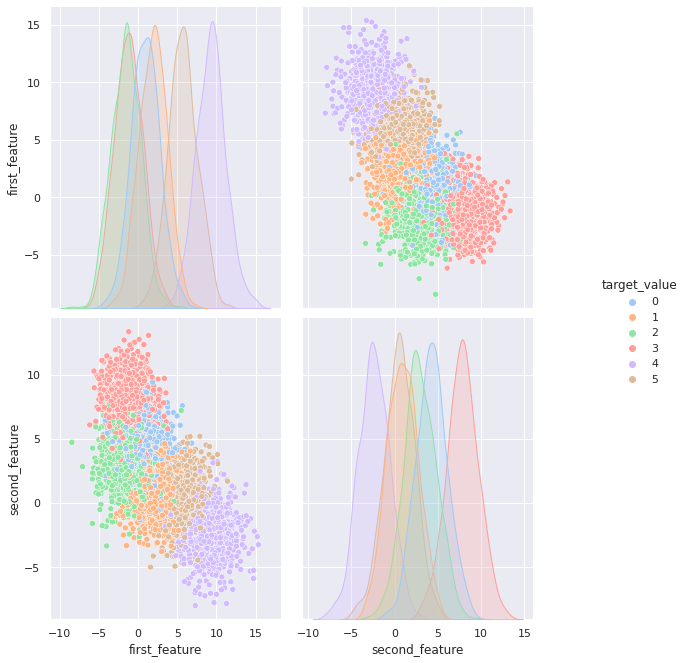

In [80]:
g = sns.pairplot(data, hue='target_value', palette='pastel')
g.fig.set_size_inches(10,10)

## Интерактивные графики для визуализации данных:

In [81]:
import plotly.express as px

fig = px.scatter_matrix(data, dimensions=['first_feature', 'second_feature'], color='target_value')
fig.show()

## Корреляция:

Наивный байесовский классификатор предполагает независимость признаков. Одним из способов проверки наличия зависимости (линейной) является корреляция. Значение корреляции, близкие к 0, говорят об отсутствии линейной зависимости. В данном случае используется корреляция Спирмена, так как она является более устойчивой.

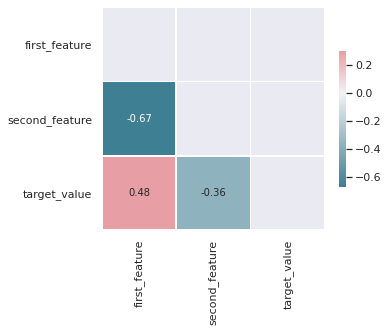

In [82]:
corr = data.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

Из heatmap видно, что корреляция между признаками составляет около -0.67, что  ближе по модулю к 1, чем к 0. Значит, между признаками есть несильная корреляция (линейная зависимость) и наивный байс, скорее всего, не даст идеальных результатов.

# **Разбивка на train-test**

In [83]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target_value']), data['target_value'], test_size = 0.5, random_state = 42)

# **Реализация наивного байесовского классификатора:**

In [84]:
class NaiveBayesClassifier:

  def fit(self, X_train, y_train):
    self.means = X_train.groupby(y_train).mean()
    self.stds = X_train.groupby(y_train).std()
    # априорная вероятность классов (количество элементов класса, деленное на общее количество элементов в тренировочном наборе)
    self.probs = X_train.groupby(y_train).apply(lambda x: len(x) / X_train.shape[0])
  
  def predict(self, X_test):
    y_pred = []
    for elem in range(X_test.shape[0]):
      p = {}
      for cl in np.unique(y_train):
        # априорная вероятность для каждого класса
        p[cl] = self.probs.iloc[cl]
        for index, param in enumerate(X_test.iloc[elem]):
          # вычисляется функция правдоподобия и сразу же умножается на полученную выше априорную вероятность класса
          #  P(H|A) ~ P(H)P(A|H), апостериорная вероятность ~ априорная вероятность * функцию правдопободия
          p[cl] *= norm.pdf(param, self.means.iloc[cl, index], self.stds.iloc[cl, index])
      y_pred.append(pd.Series(p).values.argmax())
    return y_pred

In [85]:
time_NB = []
for iter in range(num_iterations):
  start = time.time()
  model = NaiveBayesClassifier()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  time_NB.append(float(time.time() - start))

In [86]:
score = accuracy_score(y_test, y_pred)
accuracy.at['реализованный НБ', 'accuracy'] = score 

## Оценка работы реализации наивного байеса:

In [87]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[216  39  40  42   0   7]
 [ 55 236  51   0   0  50]
 [ 75  31 245  41   0   0]
 [ 45   0  18 329   0   0]
 [  0   0   0   0 362  48]
 [  5  56   0   0  35 272]]


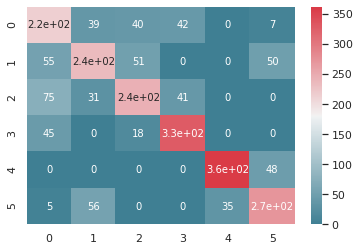

In [88]:
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.63      0.58       344
           1       0.65      0.60      0.63       392
           2       0.69      0.62      0.66       392
           3       0.80      0.84      0.82       392
           4       0.91      0.88      0.90       410
           5       0.72      0.74      0.73       368

    accuracy                           0.72      2298
   macro avg       0.72      0.72      0.72      2298
weighted avg       0.73      0.72      0.72      2298



# **Классифкаторы из sklearn:**

In [90]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.preprocessing import MinMaxScaler

## GaussianNB

In [91]:
time_gaussian = []
for iter in range(num_iterations):
  
  start = time.time()

  model_gaussian = GaussianNB()
  model_gaussian.fit(X_train, y_train)
  pred_gaussian = model_gaussian.predict(X_test)

  time_gaussian.append(float(time.time() - start))


In [92]:
score = accuracy_score(y_test, pred_gaussian)
accuracy.at['gaussianNB', 'accuracy'] = score 

### Оценка качества GaussianNB:

In [93]:
conf_matrix = confusion_matrix(y_test, pred_gaussian)
print(conf_matrix)

[[216  39  40  42   0   7]
 [ 55 236  51   0   0  50]
 [ 75  31 245  41   0   0]
 [ 45   0  18 329   0   0]
 [  0   0   0   0 362  48]
 [  5  56   0   0  35 272]]


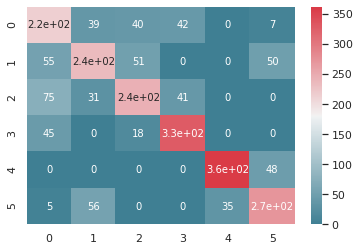

In [94]:
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

In [95]:
print(classification_report(y_test, pred_gaussian))

              precision    recall  f1-score   support

           0       0.55      0.63      0.58       344
           1       0.65      0.60      0.63       392
           2       0.69      0.62      0.66       392
           3       0.80      0.84      0.82       392
           4       0.91      0.88      0.90       410
           5       0.72      0.74      0.73       368

    accuracy                           0.72      2298
   macro avg       0.72      0.72      0.72      2298
weighted avg       0.73      0.72      0.72      2298



## Масштабирование признаков:

In [96]:
# производится нормализация, так как классификаторы далее не работает с отрицательными значениями

scaler = MinMaxScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## MultinomialNB

In [97]:
# качество работы зависит от данных, MultinomialNB, как правило, показывает лучший результат на дискретных данных
time_multinomail = []
for iter in range(num_iterations):
  start = time.time()

  model_multinomail = MultinomialNB()
  model_multinomail.fit(X_train_scaled, y_train)
  pred_multinomail = model_multinomail.predict(X_test_scaled)

  time_multinomail.append(float(time.time() - start))

In [98]:
score = accuracy_score(y_test,  pred_multinomail)
accuracy.at['multinomailNB', 'accuracy'] = score 

### Оценка качества MultinomialNB:

In [99]:
conf_matrix = confusion_matrix(y_test,  pred_multinomail)
print(conf_matrix)

[[343   0   0   0   0   1]
 [347   0   0   0   0  45]
 [391   0   0   1   0   0]
 [391   0   0   1   0   0]
 [  1   0   0   0  23 386]
 [120   0   0   0   0 248]]


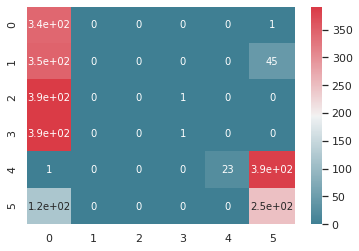

In [100]:
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

In [101]:
print(classification_report(y_test, pred_multinomail))

              precision    recall  f1-score   support

           0       0.22      1.00      0.35       344
           1       0.00      0.00      0.00       392
           2       0.00      0.00      0.00       392
           3       0.50      0.00      0.01       392
           4       1.00      0.06      0.11       410
           5       0.36      0.67      0.47       368

    accuracy                           0.27      2298
   macro avg       0.35      0.29      0.16      2298
weighted avg       0.35      0.27      0.15      2298



## ComplementNB

In [102]:
# качество работы зависит от данных, ComplementNB, как правило, показывает лучший результат на несбалансированных данных 
# в нашем случае каждый класс имеет одинаковое количество элементов -> данные сбалансированны
time_complement = []
for iter in range(num_iterations):
  
  start = time.time()
  model_complement = ComplementNB()
  model_complement.fit(X_train_scaled, y_train)
  pred_complement = model_complement.predict(X_test_scaled)
  time_complement.append(float(time.time() - start))

In [103]:
score = accuracy_score(y_test,  pred_complement)
accuracy.at['complementNB', 'accuracy'] = score 

### Оценка качества ComplementNB:

In [104]:
conf_matrix = confusion_matrix(y_test, pred_complement)
print(conf_matrix)

[[  0   0   0 310  34   0]
 [  0   0   0 154 238   0]
 [  0   0   0 378  14   0]
 [  0   0   0 392   0   0]
 [  0   0   0   0 410   0]
 [  0   0   0   7 361   0]]


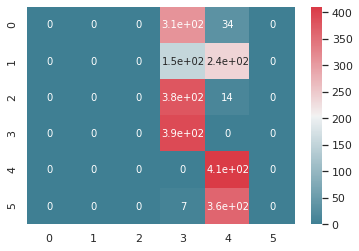

In [105]:
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

In [106]:
print(classification_report(y_test, pred_complement))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       344
           1       0.00      0.00      0.00       392
           2       0.00      0.00      0.00       392
           3       0.32      1.00      0.48       392
           4       0.39      1.00      0.56       410
           5       0.00      0.00      0.00       368

    accuracy                           0.35      2298
   macro avg       0.12      0.33      0.17      2298
weighted avg       0.12      0.35      0.18      2298



## BernoulliNB

In [107]:
# качество работы зависит от данных, BernoulliNB, как правило, показывает лучший результат на бинарных данных
time_bernoulli = []
for iter in range(num_iterations):
  
  start = time.time()
  model_bernoulli = BernoulliNB()
  model_bernoulli.fit(X_train_scaled, y_train)
  pred_bernoulli = model_bernoulli.predict(X_test_scaled)
  time_bernoulli.append(float(time.time() - start))


In [108]:
score = accuracy_score(y_test,  pred_bernoulli)
accuracy.at['bernoulliNB', 'accuracy'] = score 

### Оценка качества BernoulliNB:

In [109]:
conf_matrix = confusion_matrix(y_test, pred_bernoulli)
print(conf_matrix)

[[344   0   0   0   0   0]
 [392   0   0   0   0   0]
 [391   0   1   0   0   0]
 [392   0   0   0   0   0]
 [410   0   0   0   0   0]
 [368   0   0   0   0   0]]


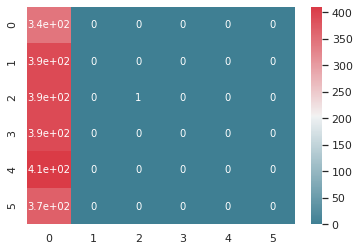

In [110]:
sns.heatmap(conf_matrix, cmap = cmap, annot=True)

In [111]:
print(classification_report(y_test, pred_bernoulli))

              precision    recall  f1-score   support

           0       0.15      1.00      0.26       344
           1       0.00      0.00      0.00       392
           2       1.00      0.00      0.01       392
           3       0.00      0.00      0.00       392
           4       0.00      0.00      0.00       410
           5       0.00      0.00      0.00       368

    accuracy                           0.15      2298
   macro avg       0.19      0.17      0.04      2298
weighted avg       0.19      0.15      0.04      2298



# Оценка производительности алгоритмов:

In [112]:
times = pd.DataFrame({
    'Реализация наивного байеса': time_NB,
    'gaussianNB': time_gaussian,
    'multinomailNB': time_multinomail,
    'bernoulliNB': time_bernoulli,
    'complementNB': time_complement
})

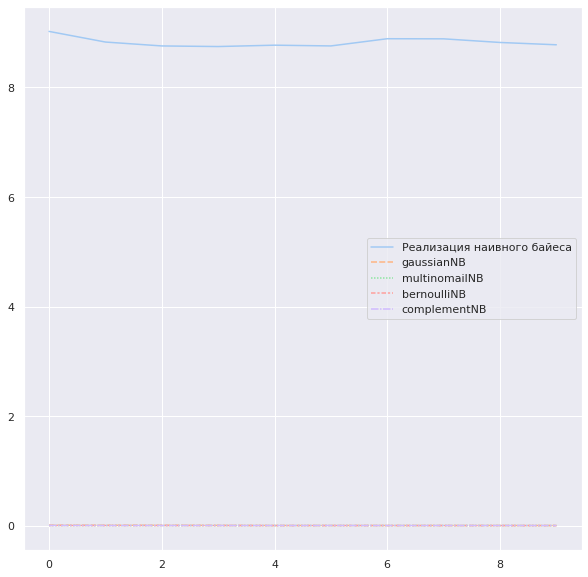

In [113]:
sns.set_theme(style="darkgrid")

fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=times,
             palette='pastel')

Видно, что реализация наивного байеса - самая медленная, остальные графики сливаются. Поэтому, построим отдельно график для библиотечных алгоритмов и отдельно график для собственной реализации:

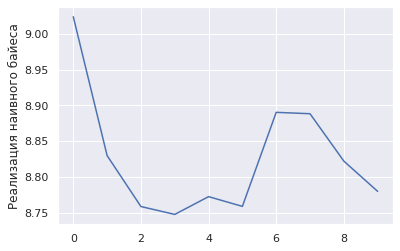

In [114]:
sns.lineplot(data=times['Реализация наивного байеса'],
             palette='pastel')

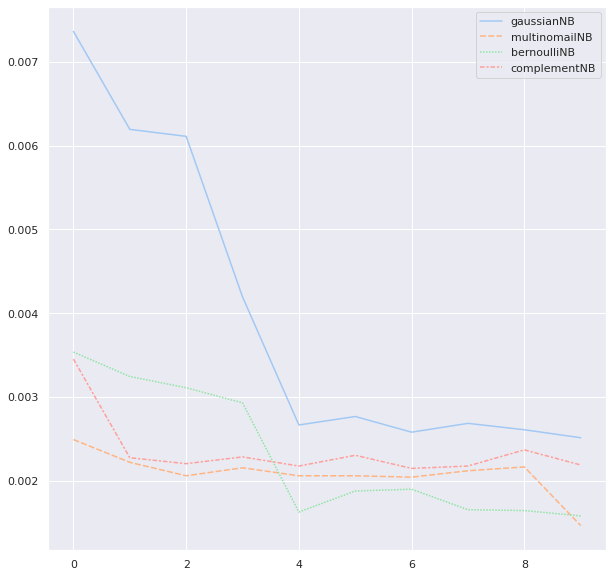

In [115]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(data=times.drop('Реализация наивного байеса', axis=1),
             palette='pastel')

Аналогичная ситуация с гистограммами, поэтому их так же две: для всех типов алгоритмов и для алгоритмов из скилерн.

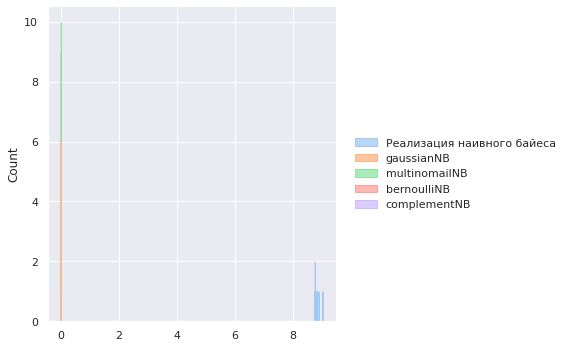

In [116]:
sns.displot(times, element="step",  palette='pastel')

In [117]:
# интерактивный график для лучшей видимости, справа можно выбирать для каких алгоритмов будут рисоваться гистограммы
# легенда является интерактивной, поэтому можно выбирать гистограмму для любой комбинации алгоритмов
# видно, что собственная реализация наивного Байеса достаточно медленная, поэтому реализации из скилерна сливаются
# если убрать собственную реализацию с гистограммы, то станет нагляднее

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=times['bernoulliNB'], name='bernouliNB'))
fig.add_trace(go.Histogram(x=times['gaussianNB'], name='gaussianNB'))
fig.add_trace(go.Histogram(x=times['multinomailNB'], name='multinomailNB'))
fig.add_trace(go.Histogram(x=times['complementNB'], name='complenetNB'))
fig.add_trace(go.Histogram(x=times['Реализация наивного байеса'], name='Реализация наивного байеса'))

fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

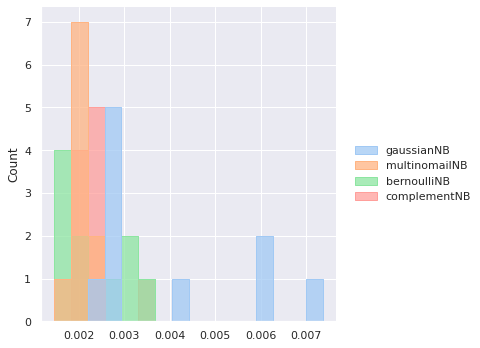

In [118]:
# статичная реализация гистограммы для скилерн алгоритмов
sns.displot(times.drop('Реализация наивного байеса', axis=1), element="step", palette='pastel')

Если рассматривать стабильную производительность в контексте затраченного времени (без учета точности), то лучший вариант - multinomailNB или complenetNB, потому что он довольно быстрый и не имеет такого временного разброса как остальные.

Для этого посмотрим std и mean для каждого:

In [119]:
times.describe()

,Реализация наивного байеса,gaussianNB,multinomailNB,bernoulliNB,complementNB
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,8.827044,0.003968,0.002083,0.002310,0.002357
std,0.086525,0.001881,0.000255,0.000791,0.000391
min,8.747479,0.002513,0.001464,0.001579,0.002146
25%,8.762113,0.002623,0.002059,0.001646,0.002178
50%,8.800838,0.002725,0.002088,0.001887,0.002238
75%,8.873568,0.005633,0.002162,0.003065,0.002298
max,9.023744,0.007365,0.002491,0.003536,0.003451


У multinomailNB среднее значение меньше, но разброс немного больше, чем у complementNB, в результате mean-std и mean+std у multinomailNB меньше. Можно сказать, что он даёт лучшую производительность по времени.

# Лучший классификатор:

In [120]:
quality = accuracy.accuracy.sort_values(ascending=False).to_frame()
quality

,accuracy
gaussianNB,0.722367
реализованный НБ,0.722367
complementNB,0.348999
multinomailNB,0.267624
bernoulliNB,0.150131


In [121]:
# точность реализованного и библиотечного наивного байеса одинакова?

quality.accuracy[0] == quality.accuracy[1]

True

Наилучшую точность обеспечили два алгоритма: GaussianNB и собственная реализация наивного байеса, однако, время работы меньше у алгоритма GaussianNB, следовательно, его использование предпочтительнее и в текущих условиях он даёт наилучший результат.

# Исследование стабильности производительности и точности классификаторов в разрезе изменения соотношения выборок

In [122]:
# я хочу рассмотреть и выбрать лучший алгоритм в контексте разных разбиок train-test
# так как данные сбалансированны, то, скорее всего, наилучшую точность будут также обеспечивать реализованный наивный байес и gaussianNB

test_sizes = [.1, .15, .2, .25, .3, .35, .4, .45, .5, .55 ]
time_NB, time_gaussian, time_bernoulli, time_complement, time_multinomail = [], [], [], [], []
accuracy_NB, accuracy_gaussian, accuracy_bernoulli, accuracy_complement, accuracy_multinomail = [], [], [], [], []

for i, test_size in enumerate(test_sizes):
  X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target_value']), data['target_value'], test_size = test_size, random_state=42)

  for iter in range(num_iterations):

    # собственная реализация наивного байеса
    start = time.time()
    model = NaiveBayesClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    time_NB.append(float(time.time() - start))
    score = accuracy_score(y_test, y_pred)
    accuracy_NB.append(score)

    # скилерн реализации
    start = time.time()
    model_gaussian = GaussianNB()
    model_gaussian.fit(X_train, y_train)
    pred_gaussian = model_gaussian.predict(X_test)
    time_gaussian.append(float(time.time() - start))
    score = accuracy_score(y_test, pred_gaussian)
    accuracy_gaussian.append(score)

    ## масштабирование признаков для решения проблемы с отрицательными числами
    scaler = MinMaxScaler()
    X_train_scaled= scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    start = time.time()
    model_multinomail = MultinomialNB()
    model_multinomail.fit(X_train_scaled, y_train)
    pred_multinomail = model_multinomail.predict(X_test_scaled)
    time_multinomail.append(float(time.time() - start))
    score = accuracy_score(y_test, pred_multinomail)
    accuracy_multinomail.append(score)

    start = time.time()
    model_complement = ComplementNB()
    model_complement.fit(X_train_scaled, y_train)
    pred_complement = model_complement.predict(X_test_scaled)
    time_complement.append(float(time.time() - start))
    score = accuracy_score(y_test, pred_complement)
    accuracy_complement.append(score)

    start = time.time()
    model_bernoulli = BernoulliNB()
    model_bernoulli.fit(X_train_scaled, y_train)
    pred_bernoulli = model_bernoulli.predict(X_test_scaled)
    time_bernoulli.append(float(time.time() - start))
    score = accuracy_score(y_test, pred_bernoulli)
    accuracy_bernoulli.append(score)

In [123]:
# графики время-точность для выбора лучшего и стабильного классификатора:

# датафреймы с результатами
results_NB = pd.DataFrame({'accuracy': accuracy_NB, 'time': time_NB})
results_gaussian = pd.DataFrame({'accuracy': accuracy_gaussian, 'time': time_gaussian})
results_multinomail = pd.DataFrame({'accuracy': accuracy_multinomail, 'time': time_multinomail})
results_complement = pd.DataFrame({'accuracy': accuracy_complement, 'time': time_complement})
results_bernoulli = pd.DataFrame({'accuracy': accuracy_bernoulli, 'time': time_bernoulli})

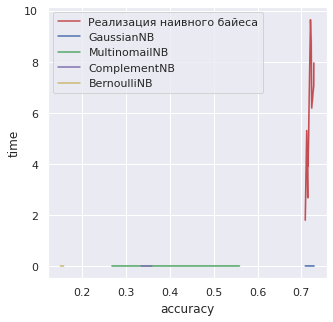

In [124]:
fig_dims = (5, 5)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(x = results_NB.accuracy, y=results_NB.time, data=results_NB,
             palette='pastel', color='r', label='Реализация наивного байеса')
sns.lineplot(x = results_gaussian.accuracy, y=results_gaussian.time, data=results_gaussian,
             palette='pastel', color='b', label='GaussianNB')
sns.lineplot(x = results_multinomail.accuracy, y=results_multinomail.time, data=results_multinomail,
             palette='pastel', color='g', label='MultinomailNB')
sns.lineplot(x = results_complement.accuracy, y=results_complement.time, data=results_complement,
             palette='pastel', color='m', label='ComplementNB')
sns.lineplot(x = results_bernoulli.accuracy, y=results_bernoulli.time, data=results_bernoulli,
             palette='pastel', color='y', label='BernoulliNB')

из-за большой разницы во времени работы для стандартных алгоритмов из склилерна и реализации наивного байеса график выглядит не очень информативным, но можно сказать, что в разрезе точность/время:
-  лучший результат у GaussianNB, потому что он имеет маленький диапазон изменения точности и довольно быстрое исполнение.
-  худший результат даёт MultinomailNB, так как несмотря на быстрое испольнение, он имеет большой разброс в точности.
-  небольшой разброс в точности и быстрое выполнение есть у BernoulliNB и ComplementNB, но значения в диапазоне низкие, т.е. алгоритмы плохо справляются.

Поэтому можно утверждать, что GaussianNB является алгоритмом, обеспечивающим стабильную производительность в разрезе точность/время.

Посмотрим детально на точность двух лучших алгритмов (согласно предыдущим выводам):

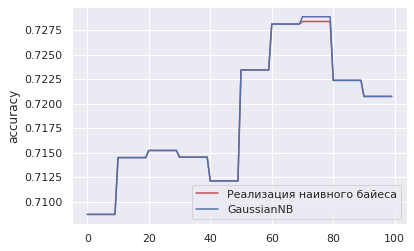

In [125]:
# только точность для алгоритмов, дающих наилучший результат точности

sns.lineplot(data=results_NB.accuracy,
             palette='pastel', color='r', label='Реализация наивного байеса')
sns.lineplot(data=results_gaussian.accuracy,
             palette='pastel', color='b', label='GaussianNB')

In [126]:
print('Реализация: ', results_NB.accuracy.mean())
print('Скилерн: ', results_gaussian.accuracy.mean())

Реализация:  0.7188060524676477
Скилерн:  0.718854384995439


Видно, что практически на всех участках точность у собственной реализации наивного байеса и наивного байеса из скилерн совпадает.

Исключение составляет участок между 60 и 80, там лучший результат у наивного байеса из библиотеки скилерн.

Таким образом, самую высокую точность обеспечивает GaussianNB.

#<center>**Выводы:**</center>





1. При первичном исследовании производительности алгоритмов рассматривалось только время работы (согласно заданию). Для этого измерялось время работы каждого алгоритма на 10 итерациях, в результате было получено, что *MultinomailNB даёт лучший результат по времени, так как среднее значение времени выполнения алгоритма самое маленькое (с учётом СКО)*.

2. Также проводилось исследование для определения алгоритма, обеспечивающего стабильную производительность в контекте точности/времени выполнения. Для этого train-test наборы разбивались в разном соотношении. Всего было проведено 100 вычислительных экспериментов, на основе которых были получены следующий вывод: *лучший результат показала реализация наивного байеса из библиотеки скилерн, так как она даёт лучшее значение точности (и маленький диапазон разброса значения) + быстрое выполнение.*

3. Для определения алгоритма, дающего лучшее значение точности, также использовались данные из предыдущего пункта, только они исследовались в разрезе точности, без учёта времени. Так как на предыдущих этапах анализа было выявлено, что реализация наивного байеса из скилерна и собственная реализация дают лучшие результаты (одинаковые), то сравнивались только они. При построении графика для 100 измерений было обнаружено, что *GaussianNB даёт результат лучше* (на небольшом участке графика значение точности выше, на остальных - совпадает).



